# GPT-2 interpretability

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/days/w1d6/gpt-2_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logit lens

Read : https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens

Then try to reimplement it in a minimal way by reproducing the figure at the end of this section.


Resources:
- Read about hooks here https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks
- pip install transformer-utils and use the function _plot_logit_lens https://github.dev/nostalgebraist/transformer-utils/tree/main/src/transformer_utils/logit_lens


In [1]:
!pip install transformers transformer_utils -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00


In [2]:
import torch
import transformers

# Minimal example
model = transformers.AutoModelForCausalLM.from_pretrained('gpt2')
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model.eval()

def text_to_input_ids(text):
    toks = tokenizer.encode(text)
    return torch.as_tensor(toks).view(1, -1)


input_ids = text_to_input_ids("Happy birthday to You, happy")
print(input_ids)

# Tip: Use torch hooks, and do not forget the last layerNorm layer!
# Hooks documentation: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks
# Example of usage of hooks here: https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/Grad_CAM_easy_mode.ipynb

tensor([[25082, 10955,   284,   921,    11,  3772]])


In [3]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


Steps : 
- Take the activations from each layer
  - For transformer experts: the "activations" here are the block outputs after layer norm, but before the learned point-wise transformation.
  - 1600-dim vectors produced in the middle of the network
- Convert the activations back to the vocabulary space
  - We have a "dictionary," W, that lets us convert between vocab space and embedding space at any point. 
  - At the end, the final 1600-dimensional vector is multiplied by W's transpose to project back into vocab space.

In [4]:
nb_layers = len(model.transformer.h)
print("Number GPT blocks : ", nb_layers)
outputs = [None] * nb_layers
handles = [None] * nb_layers

def make_memorize_output_layer(layer):
    def memorize_output_layer(self, input, output):
        global outputs 
        # Rmq: global is not necessary, because we are just mofying the content of a list.
        # global would have been necessary if we were modifying a variable.
        outputs[layer] = output[0].detach()
    return memorize_output_layer

for i in range(nb_layers):
  handles[i] = model.transformer.h[i].register_forward_hook(make_memorize_output_layer(i))

Number GPT blocks :  12


In [5]:
input_ids = text_to_input_ids("Happy birthday to you, happy birthday to")
model(input_ids)
len(outputs)

12

In [6]:
# Without detach
print(model.transformer.wte.weight)
# With detach
print("After detach : not a parameter anymore")
print(model.transformer.wte.weight.detach())

Parameter containing:
tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
       requires_grad=True)
After detach : not a parameter anymore
tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]])


In [7]:
input_ids = text_to_input_ids("Happy birthday to you, happy birthday to")
model(input_ids)

layer_preds = []
layer_logits = []
layer_probs = []

ln_f = model.transformer.ln_f
word_embeddings = model.transformer.wte.weight.detach()

for layer_i, output in enumerate(outputs):
  normalized_output = ln_f(output)

  ## Matrix multiplication with the transpose of W to get the word representation
  ## batch matrix multiplication : ('bij,bjk->bik', As, Bs) but with transpose
  word_distributions = torch.einsum("bij,kj->bik", normalized_output, word_embeddings) # torch.Size([1, 8, 50257])

  best_word = torch.argmax(word_distributions, dim=2) # torch.Size([1, 8])
  best_text = tokenizer.decode(best_word[0]) # best_word[0] : torch.Size([8])
  print(best_text)

  layer_preds.append(best_word) 
  layer_logits.append(word_distributions) 
  layer_probs.append(torch.softmax(word_distributions, dim=2)) 


 birthday get're which happy anniversary get
, birthday get're which happy anniversary get
, holidays celebrate guys please happy anniversary get
, anniversary celebrate guys please happy anniversary be
, anniversary celebrate guys please happy! celebrate
, anniversary celebrate guys please birthday! be
,! thank guys dear birthday! everyone
,! thank guys dear birthday! everyone
,! my guys dear birthday to everyone
,! my guys dear birthday to everyone
, to my guys dear birthday to everyone
,, you, my birthday to all


In [8]:
print(type(layer_logits))

def to_tensor(list_tensor):
  # return a tensor of tensors from list of tensors
  return torch.squeeze(torch.stack(list_tensor).detach(),1)

# SOL
from typing import List

def to_tensor(list_tensor : List[torch.Tensor]) -> torch.Tensor:
    list_tensor = [t.detach() for t in list_tensor]
    return torch.concat(list_tensor, dim=0)

<class 'list'>


ValueError: ignored

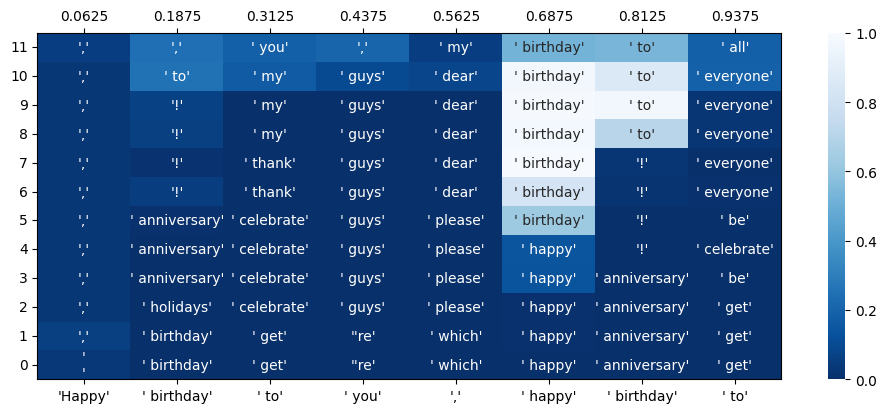

In [9]:
from transformer_utils.logit_lens.plotting import _plot_logit_lens
n_layers_gpt = nb_layers

_plot_logit_lens(
    to_tensor(layer_logits),
    to_tensor(layer_preds),
    to_tensor(layer_probs),
    tokenizer,
    input_ids=input_ids,
    start_ix=0,
    layer_names=[i for i in range(n_layers_gpt)],
    probs=True,
    ranks=False,
    kl=False,
    top_down=False,
)

## Probing

Look at this youtube video to introduce you to probing: https://www.youtube.com/watch?v=HJn-OTNLnoE

We will use the fetch_20newsgroups dataset, and we will classify the news.
We will try to implement a small probe. Analyse each layer of GPT-2. Which layer contains most of the information we are insterested with?

Questions: 
- What is your strategy to use the internal states of gpt-2 as features for classification?
- Propose 2 other strategies that won't work.
- Try to predict the score of each layer at classifying the fetch_20newsgroups dataset.
- Implement and check your prediction.

Bonu read this: https://arxiv.org/pdf/1704.01444.pdf



In [10]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
              
twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

In [11]:
print(twenty_train.data[0])

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



In [12]:
twenty_train.target[0]

1

In [13]:
twenty_train.target_names[twenty_train.target[0]]

'comp.graphics'

In [14]:
len(twenty_train.target)

2257

https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.CausalLMOutputWithCrossAttentions

In [15]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [17]:
import numpy as np
import torch
from tqdm.auto import tqdm

torch.cuda.empty_cache()
embed_dim = 768 # after encoder
n_layers = 12
N = len(twenty_train.data)

# We only take the last token
# If you do not put everything in a single array, the memory explodes
hidden_states = np.zeros((N, n_layers, embed_dim))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

activations = np.zeros((N, n_layers, embed_dim))

model = model.to(device)
model.eval()


with torch.no_grad():
# Fill hidden_states
    for i, text in tqdm(enumerate(twenty_train.data), total=N):
        # input_ids = text_to_input_ids(data).to(device) # [1,nb_tokens]
        input_ids = tokenizer.encode(text, return_tensors="pt", truncation=True)
        input_ids = input_ids.to(device)
        output = model(input_ids, output_hidden_states=True) # [13], [1,nb_tokens, 768]
        # print(output.hidden_states[0].shape) # ([1, nb_tokens, 768])
        
        ## Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        # We skip the first layer only containing the embeddings
        hidden_states_np = [layer_emb.cpu().detach().numpy() for layer_emb in output.hidden_states[1:]]

        # We save only the last token
        ## why ?
        hidden_states[i] = np.concatenate([layer_emb[:, -1, :] for layer_emb in hidden_states_np], axis=0) # (12, 768)
        # layer_emb[:, -1, :] : (1, 768)

  0%|          | 0/2257 [00:00<?, ?it/s]

In [18]:
np.save("hidden_states", hidden_states)
hidden_states.shape

(2257, 12, 768)

In [ ]:
# If you do not have a gpu, use this line.
# hidden_states = np.load("hidden_states.npy")

In [20]:
# Check the documentation of sklearn and use those imports to score each layer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scores = []
for layer_i in range(n_layers):
    X = hidden_states[:, layer_i, :]
    y = twenty_train.target[:len(X)]

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    ## probes : linear network
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    pipe.fit(X_train, y_train)

    score = pipe.score(X_test, y_test) 
    print(layer_i, score)
  
    scores.append(score)
  

0 0.7469026548672566
1 0.7486725663716814
2 0.7823008849557522
3 0.7646017699115044
4 0.7522123893805309
5 0.720353982300885
6 0.736283185840708
7 0.7168141592920354
8 0.7398230088495575
9 0.7628318584070797
10 0.8495575221238938
11 0.8265486725663717


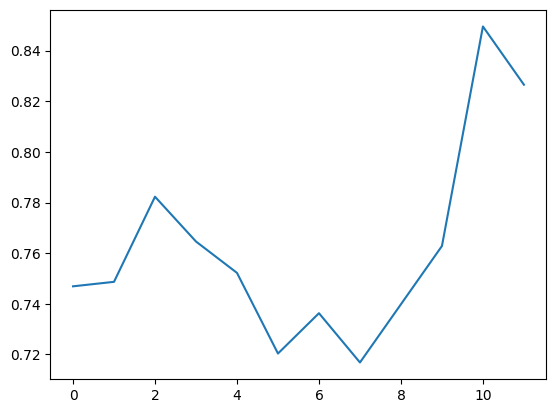

In [21]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(scores))), scores)

# Activation Atlas

With out dataset we can also try to minimally reproduce the activation atlas paper:
https://openai.com/blog/introducing-activation-atlases/


Questions:
- How to implement dimensionality reduction?
- Install umap-learn.
- Visualize the umap of the best previously selected layer. Comment.

Bonus: Plot the sentences alongside the point in the UMAP plot. Chack that everything makes sense.

Other codes : 
- https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/activation-atlas/class-activation-atlas.ipynb
- https://github.com/tensorflow/lucid/blob/master/notebooks/activation-atlas/activation-atlas-simple.ipynb
- https://github.com/emilierp/ML4G/blob/main/days/w1d6/gpt-2_interpretability_sol.ipynb

In [23]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering library
import umap as umap

<ipython-input-30-fdad0302a345>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');


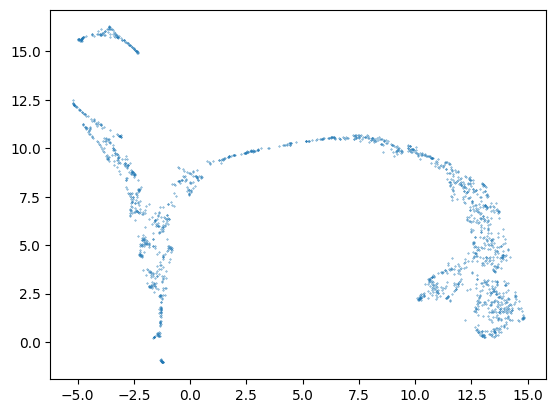

In [30]:
# Choose the best_layer
## From the scores in probing
best_layer = 2
X = hidden_states[:, best_layer, :]
y = twenty_train.target

standard_embedding = umap.UMAP(random_state=42).fit_transform(X_train)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y.astype(int), s=0.1, cmap='Spectral');
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');

# Hooks

The original code is in : 
https://colab.research.google.com/drive/1MjdfK2srcerLrAJDRaJQKO0sUiZ-hQtA?usp=sharing#scrollTo=11X1oaLHxKMQ

https://github.com/nostalgebraist/transformer-utils/tree/main/src/transformer_utils

Some other hooks examples

https://github.com/ashutosh1919/explainable-cnn/blob/main/src/explainable_cnn/explainers/grad_cam.py 

In [ ]:
 def save_fmaps(key):
    def forward_hook(module, input, output):
        self.fmap_pool[key] = output.detach()

    return forward_hook

def save_grads(key):
    def backward_hook(module, grad_in, grad_out):
        self.grad_pool[key] = grad_out[0].detach()

    return backward_hook